- [데이터셋 출처](https://www.kaggle.com/c/digit-recognizer/overview)

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv('../data/digit-recognizer/train.csv')
display(df.head(), df.shape)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(42000, 785)

In [4]:
# 결측치 확인
display(df.isnull().sum().sum())
# 결측치 없음

0

In [5]:
# 이상치 뭘 봐야 이상치인지 모르겠음...

In [6]:
# training data set
x_data = df.drop(columns=['label']).values.reshape(-1,784)
t_data = df['label'].values

In [7]:
# label one hot encoding
sess = tf.Session()
t_data_onehot = sess.run(tf.one_hot(t_data, depth=10))

In [8]:
# 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(x_data)
x_data_norm = scaler.transform(x_data)

In [9]:
# tensorflow 구현

# placeholder
X = tf.placeholder(shape=[None, 784], dtype=tf.float32)
T = tf.placeholder(shape=[None, 10], dtype=tf.float32)

# W & b
W = tf.Variable(tf.random.normal([784, 10]), name='weight')
b = tf.Variable(tf.random.normal([10]), name='bias')

# Hypothesis
logit = tf.matmul(X, W) + b
H = tf.nn.softmax(logit)

# loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, 
                                                                 labels=T))

# train
train = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

In [10]:
# parameter
num_of_epoch = 1000
batch_size = 100
# 한번에 최대한 많은 양의 데이터를 넣는게 좋긴하다

# learning

# 학습용 함수
def run_train(sess, train_x, train_t):
    print('### 학습 시작 ###')
    # 초기화
    sess.run(tf.global_variables_initializer())
    
    for step in range(num_of_epoch):
        total_batch = int(train_x.shape[0] / batch_size)
        
        for i in range(total_batch):
            batch_x = train_x[i*batch_size:(i+1)*batch_size]
            batch_t = train_t[i*batch_size:(i+1)*batch_size]
            
            _, loss_val = sess.run([train,loss], 
                                   feed_dict={X: batch_x, T: batch_t})
            
        if step % (num_of_epoch/10) == 0:
            print('loss : {}'.format(loss_val))
    print('### 학습 종료 ###')
    

# Accuracy 측정
predict = tf.argmax(H, 1)
correct = tf.equal(predict, tf.argmax(T, 1))
accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))

In [11]:
# learning with kfold
cv = 3
results = []

kf = KFold(n_splits=cv, shuffle=True)

for train_idx, val_idx in kf.split(x_data_norm):
    training_x = x_data_norm[train_idx]
    training_t = t_data_onehot[train_idx]
    
    val_x = x_data_norm[val_idx]
    val_t = t_data_onehot[val_idx]
    
    run_train(sess, training_x, training_t)
    results.append(sess.run(accuracy, feed_dict={X: val_x, T: val_t}))

print('측정한 각각의 결과값 : {}'.format(results))
print('최종 k-fold 교차검증을 사용한 Accuracy : {}'.format(np.mean(results)))

### 학습 시작 ###
loss : 1.7563717365264893
loss : 0.15828576683998108
loss : 0.1372399926185608
loss : 0.1297493726015091
loss : 0.1253158301115036
loss : 0.12185914814472198
loss : 0.11892298609018326
loss : 0.11636702716350555
loss : 0.11412828415632248
loss : 0.11216562241315842
### 학습 종료 ###
### 학습 시작 ###
loss : 1.8726038932800293
loss : 0.3201402425765991
loss : 0.23956674337387085
loss : 0.2111911177635193
loss : 0.19729496538639069
loss : 0.18933826684951782
loss : 0.18415065109729767
loss : 0.18036392331123352
loss : 0.17735646665096283
loss : 0.1748373657464981
### 학습 종료 ###
### 학습 시작 ###
loss : 1.8185615539550781
loss : 0.21288911998271942
loss : 0.1665959358215332
loss : 0.14666688442230225
loss : 0.13808833062648773
loss : 0.1343834549188614
loss : 0.13268011808395386
loss : 0.13185717165470123
loss : 0.13143333792686462
loss : 0.13117246329784393
### 학습 종료 ###
측정한 각각의 결과값 : [0.9105, 0.91585714, 0.90742856]
최종 k-fold 교차검증을 사용한 Accuracy : 0.9112618565559387


In [12]:
# test용 data
test_df = pd.read_csv('../data/digit-recognizer/test.csv')
test_data = test_df.values.reshape(-1,784)
test_data_norm = scaler.transform(test_data)

# Test Data Set을 이용하여 예측
result = sess.run(predict, feed_dict={X: test_data_norm})

# 예측결과를 test data에 결합
test_df.loc[:,'label'] = result

In [13]:
# 예측결과 비교 함수
def check_result(df):
    # 임의의 index 번호 생성
    tmp_num = np.random.randint(df.shape[0])
    # 임의의 index 번호에 대한 실제 데이터 그림
    plt.imshow(df.drop(columns=['label']).loc[tmp_num].values.reshape(28,28), 
               cmap='Greys')
    plt.title('Actual Value')
    plt.show()
    
    # 임의 index 번호에 대한 예측 결과
    print('Predict Value : {}'.format(df.loc[tmp_num,'label']))

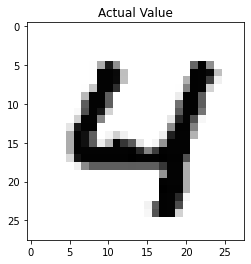

Predict Value : 4


In [14]:
check_result(test_df)

In [ ]:
# 제출 파일 작성
submission = pd.read_csv('../data/digit-recognizer/sample_submission.csv')
submission['Label'] = result
submission.to_csv('../data/digit-recognizer/submission.csv', index=False)

In [21]:
# 임의의 사진으로 예측하기
# 이미지 url을 이용해 예측을 진행하고 예측결과와 실제결과 출력
def predict_img(url):
    # 이미지 가져오기
    my_img = cv2.imread(url, cv2.IMREAD_COLOR)
    # 흑백으로 변환
    img_grey = cv2.cvtColor(my_img, cv2.COLOR_BGR2GRAY)
    # 반전
    img_grey = 255 - np.array(img_grey)
    
    # 예측용 데이터 생성
    x_data = img_grey.reshape(-1, 784)
    x_data_norm = scaler.transform(x_data)
    
    # 예측 결과
    result = sess.run(predict, feed_dict={X: x_data_norm})
    
    # 임의의 index 번호에 대한 실제 데이터 그림
    plt.imshow(x_data.reshape(28,28), cmap='Greys')
    plt.title('Actual Value')
    plt.show()
    
    # 임의 index 번호에 대한 예측 결과
    print('Predict Value : {}'.format(result))

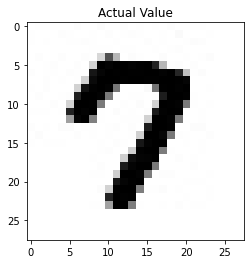

Predict Value : [7]


In [29]:
img_url = '../data/digit-recognizer/sample.jpg'
predict_img(img_url)